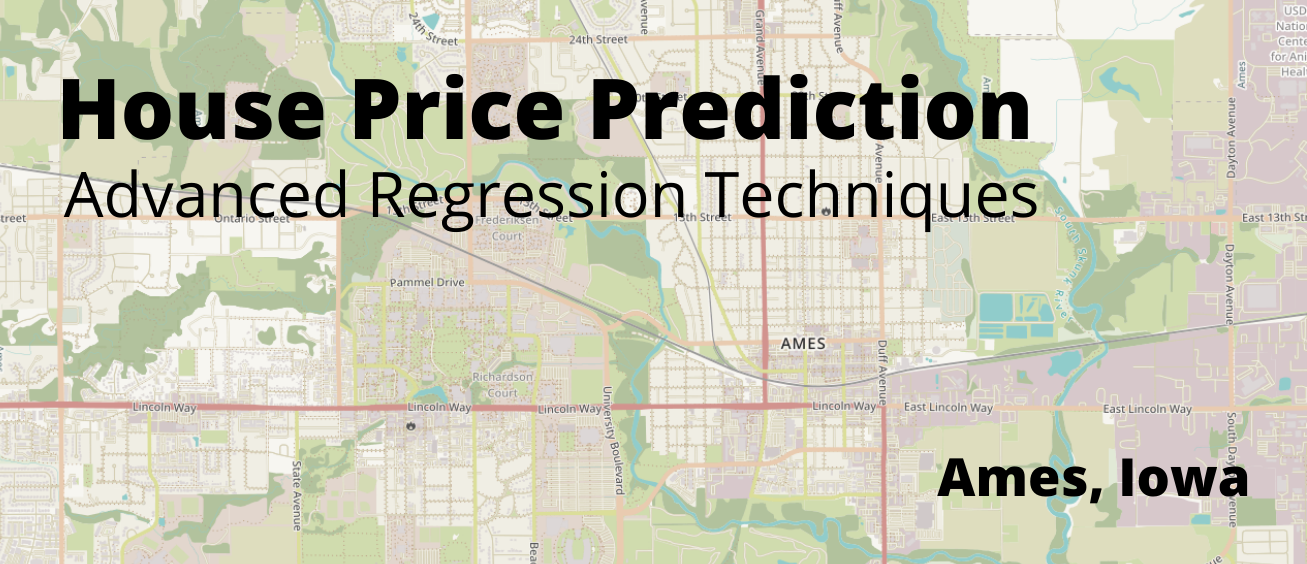

# Overview

The Ames housing dataset was compiled in 2011 as a substitute for the Boston dataset. It consists of 79 attributes about real estate, with descriptions that a buyer would never think of. Precisely because it is so descriptive, it is perfect for a machine learning task, in which we can use algorithms to find the most diverse patterns that would go unnoticed even by the most experienced broker. 

In this noteboot I will do:
1. Exploratory data analysis
     - Understand the data
     - Find interesting patterns in the dataset
2. Pre-process the data
     - Treat missing records
     - Encode categorical data
     - Remove outliers
     - Normalize the data
3. Build several models and evaluate them

# Importing libraries

In [254]:
"""Importing data manipulation and processing"""
import pandas as pd
import numpy as np

"""Importing OS and date manipulation libraries"""
import os
import datetime

"""Importing graphics and data vizualization libraries"""
import matplotlib.pyplot as plt
import seaborn as sns

"""Importing data processing and data statistics"""
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer

"""Importing model methods and metrics"""
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

"""Importing regression algorithms"""
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,  AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Importing dataset

In [255]:
"""Importing data"""
data = pd.read_csv('../data/train.csv')
data.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [256]:
"""Verifying shape"""
data.shape

(1460, 81)

## Separating the Numerical and Categorical columns

Most of the columns have a datatype that is befitting, but some of them need to be put in the right list. This happens to **MSSubClass**, **OverallQual**, and **OverallCond**.

In the case of **MSSubClass**, although this column has numerical values, the true meaning of them is just a categorization to identify the type of dwelling involved in the sale. Because of that, I will transfer it to the categorical list. The same goes for **OverallQual**, and **OverallCond**, which are numeric (ranging from 1 to 10) but they are more 
subjective and categorical, so I transfer them to the categorical list.

In the end we have **46 categorical** columns and **33 numerical** columns. 

In [257]:
numerical = [f for f in data.columns if data.dtypes[f] != 'object']
numerical.remove('SalePrice')
numerical.remove('Id')
categorical = [f for f in data.columns if data.dtypes[f] == 'object']

numerical.remove("MSSubClass")
categorical.append("MSSubClass")

""" """ 
numerical.remove("OverallQual")
numerical.remove("OverallCond")
categorical.append("OverallQual")
categorical.append("OverallCond")

print("Number of categorical columns: {}".format(len(categorical)))
print("Number of numerical columns: {}".format(len(numerical)))

Number of categorical columns: 46
Number of numerical columns: 33


## Definition of auxiliary and plot functions

In [258]:
def missing_data(columns):
    """Receives a list of columns and return a Series with the number of missing values in each column"""
    missing = data[columns].isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(ascending=False, inplace=True)
    return missing

def plot_nan(data, **kwargs):
    """Receives a Series with the missing values and plot a Bar Plot"""
    sns.set_theme(style="whitegrid", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=(10, 7))
    sns.barplot(x=data.values, y=data.index, palette="winter_r", ax=ax1, orient="h", **kwargs)
    sns.set(font_scale=2)
    ax1.set_xlabel("Number of NaN values")
    plt.plot()
    
def plot_dist(data, figsize=(10, 7), **kwargs):
    """Receives a Series and plot it's distribution"""
    sns.set_theme(style="ticks", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(data, color="g", ax=ax1, kde=True, line_kws={"lw":3}, **kwargs)
    sns.set(font_scale=2)
    plt.plot()

def box_plot(x, y, data, legend={}, figsize=(9, 7), **kwargs):
    """Receives a DataFrame and plot the x and y as a Box Plot, if the legend is provided it replaces 
    the x_tick labels"""
    plt.subplots(figsize=figsize)
    sns.set_theme(style="whitegrid", context="talk")
    sns.set(font_scale=2)
    
    x_legend, x_label = create_ticklabels(legend, x)
        
    sns.boxplot(x=x, y=y, data=data[[x, y]], **kwargs)
    if len(legend) > 10:
        plt.xticks(ticks=range(0, len(legend)), labels=x_legend, rotation=90)
    elif len(legend) <= 10 and len(legend) > 0:
        plt.xticks(ticks=range(0, len(legend)), labels=x_legend, rotation=0)
    
    plt.xlabel(x_label, size=15)    
    plt.ylabel(y, size=15)
    plt.plot()

def create_ticklabels(legend, x):
    """Receives the encoded legend and returns the x_tick labels for that plot"""
    x_legend = []
    if x[-1] == "E":
        for x_tick in range(1, len(legend)+1):
            x_legend.append(legend[x_tick])
        
        x_label = x[:-2]
    else:
        x_label = x
    return x_legend, x_label 
    
def scatter_plot(x, y, data,figsize=(9, 7), **kwargs):
    """Receives a DataFrame and plot the x and y as a Scatter Plot"""
    plt.subplots(figsize=figsize)
    sns.set_theme(style="whitegrid", context="talk")
    sns.set(font_scale=2)
    sns.scatterplot(x=x, y=y, data=data, **kwargs)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.plot()
    
def triang_corr_plot(corr, figsize=(18, 18), mask=True, square=True, cmap=False, **kwargs):
    """Receives a correlation table and plots the correlation table, in case mask is True, 
    creates a triangular plot with the unique correlations"""
    if figsize != (0, 0):
        f, ax = plt.subplots(figsize=figsize)
    
    if mask:
        mask = np.triu(np.ones_like(corr, dtype=bool))
    else:
        mask = np.zeros_like(corr, dtype=bool)
    
    if not cmap:
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
    sns.set(font_scale=2)
    sns.heatmap(corr,square=square, mask=mask, cmap=cmap, linewidths=.1, cbar_kws={"shrink": .5}, **kwargs)
    plt.plot()

def reg_plot(x, y, data, height=9, color="g", alpha=0.25, **kwargs):
    """Receives a DataFrame and plot the Regression Plot between x and y, as well as the line of the regression 
    Pearson correlation coeficient"""
    plt.figure(figsize = (9,8))
    sns.set(font_scale=2)
    sns.set_theme(style="whitegrid", context="talk")
    sns.jointplot(x=x, y=y, data=data, kind="reg", height=9, color=color, scatter_kws={'alpha':alpha})
    plt.legend(['$Pearson=$ {:.2f}'.format(data.corr()["SalePrice"][0])], loc = 'best')
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.plot()


# Initial pre-processing data

## Ploting the missing data

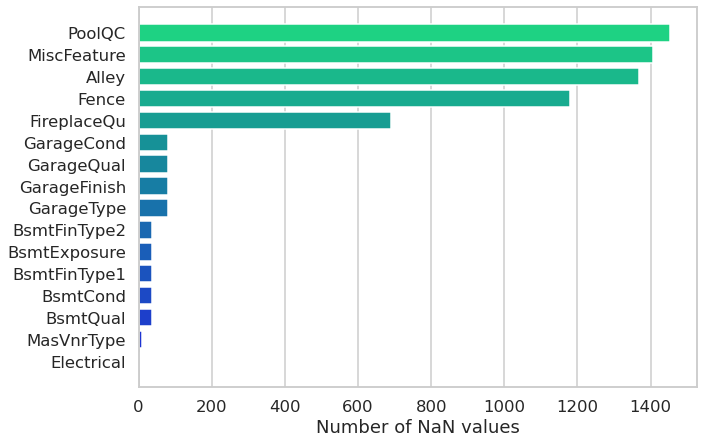

In [259]:
"""Ploting the missing data in the categorical data"""
cat_miss = missing_data(categorical)
plot_nan(cat_miss)

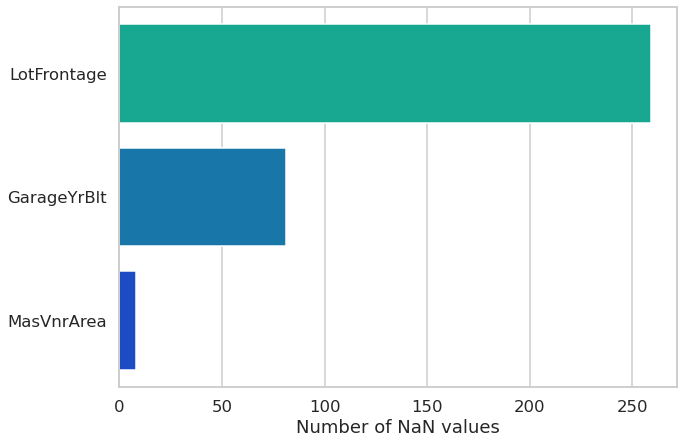

In [260]:
"""Ploting the missing data in the numerical data"""
num_miss = missing_data(numerical)
plot_nan(num_miss)

## Filling missing data
The data description for **PoolQ**, **MiscFeature**, **Alley**, **Fence**, **FireplaceQu**, **GarageCond**, **GarageQual**, **GarageFinish**, **GarageType**, **BsmtFinType2**, **BsmtExposure**, **BsmtFinType1**, **BsmtCond**, and **BsmtQual**, says clearly that the NaN values stand for No Pool, No alley access, No Garage and so on. Because of that we are going to substitute all NaN in those categorical atributes for "None". Besides that, there is a NaN value in **MasVnrType**, and e will substitute for "None" too, seeing that this class already exist.

Also, the one record that has a NaN in the **Electrical** atribute will be droped, because one record will not affect the regression algorithms.

Finally, the NaN values in the **LotFrontage**, **GarageYrBlt** and **MasVnrArea** will be set to zero because they are numerical columns.

In [261]:
"""Filling all the NaNs, and droping the missing Eletrical"""
data.dropna(subset=['Electrical'], inplace=True)
for atribute in categorical:
    data[atribute] = data[atribute].fillna('None')
    
for atribute in numerical:
    data[atribute] = data[atribute].fillna(0)

In [262]:
data.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Exploratory Analysis 
## Numerical Correlation tables

Here I choose the Spearman correlation, because it is less sensitive than the Pearson correlation to strong outliers that are in the tails of both samples, seeing that we did not treated our data yet.

The Spearman correlation will be $1$ when the function that describes the data is monotonically increasing, that is, if for all $x$ and $y$ such that ${ x\leq y}$ one has 
${\displaystyle f\!\left(x\right)\leq f\!\left(y\right)}$. Likewise, the Spearman correlation will be $-1$ when the funcion that describes the data is monotonically decreasing if, whenever $x\leq y$, then ${\displaystyle f\!\left(x\right)\geq f\!\left(y\right)}$.

This means that the relationship between the data doesn't need to be linear to have a strong correlation.

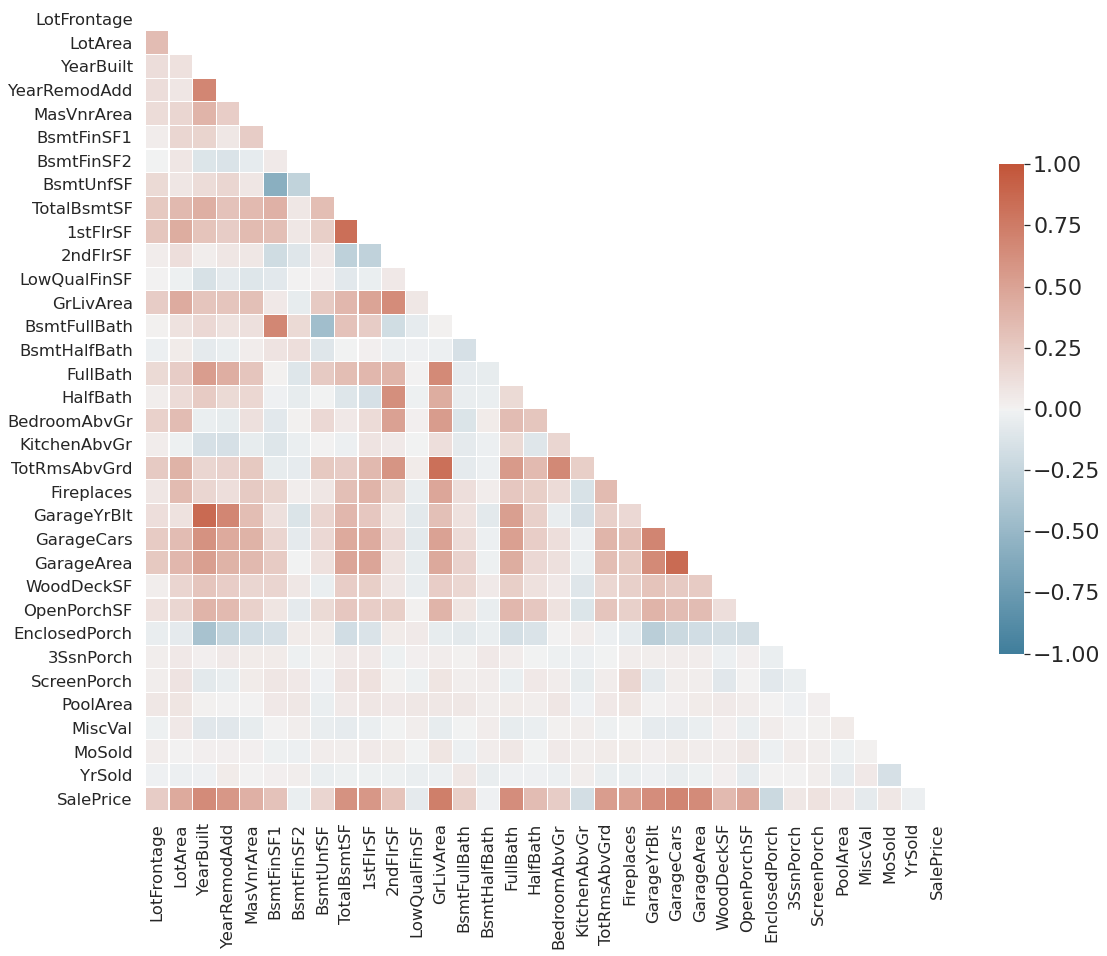

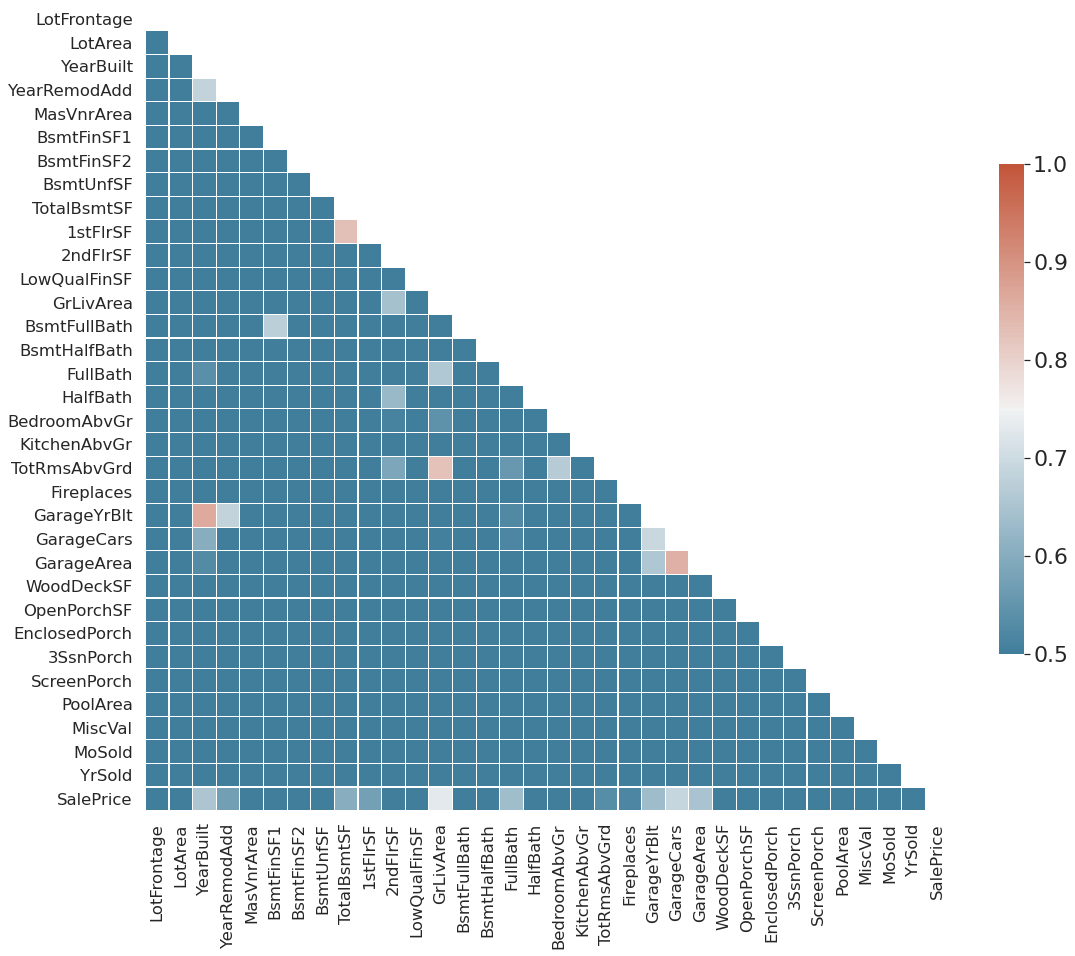

In [263]:
"""Ploting the correlation table using the Spearman correlation of the numerical variables"""
corr_num = data[numerical+["SalePrice"]].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_num, vmax=1, vmin=-1)
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_num, vmax=1, vmin=0.5)

## Encoding the Categorical atributes

Encoding the categorical variables as numbers, so we can calculate the correlation. 
Here we create the legend for the encoding, that will be used later to plot the categorical variables

In [264]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    categories = {}
    for cat, o in ordering.items():
        categories[o] = cat
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    return categories
    
cat_encoded = []
legend_cat = {}
for q in categorical:
    legend_cat[q] = encode(data, q)
    cat_encoded.append(q+'_E')
print(cat_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'MSSubClass_E', 'OverallQual_E', 'OverallCond_E']


## Categorical Correlation tables

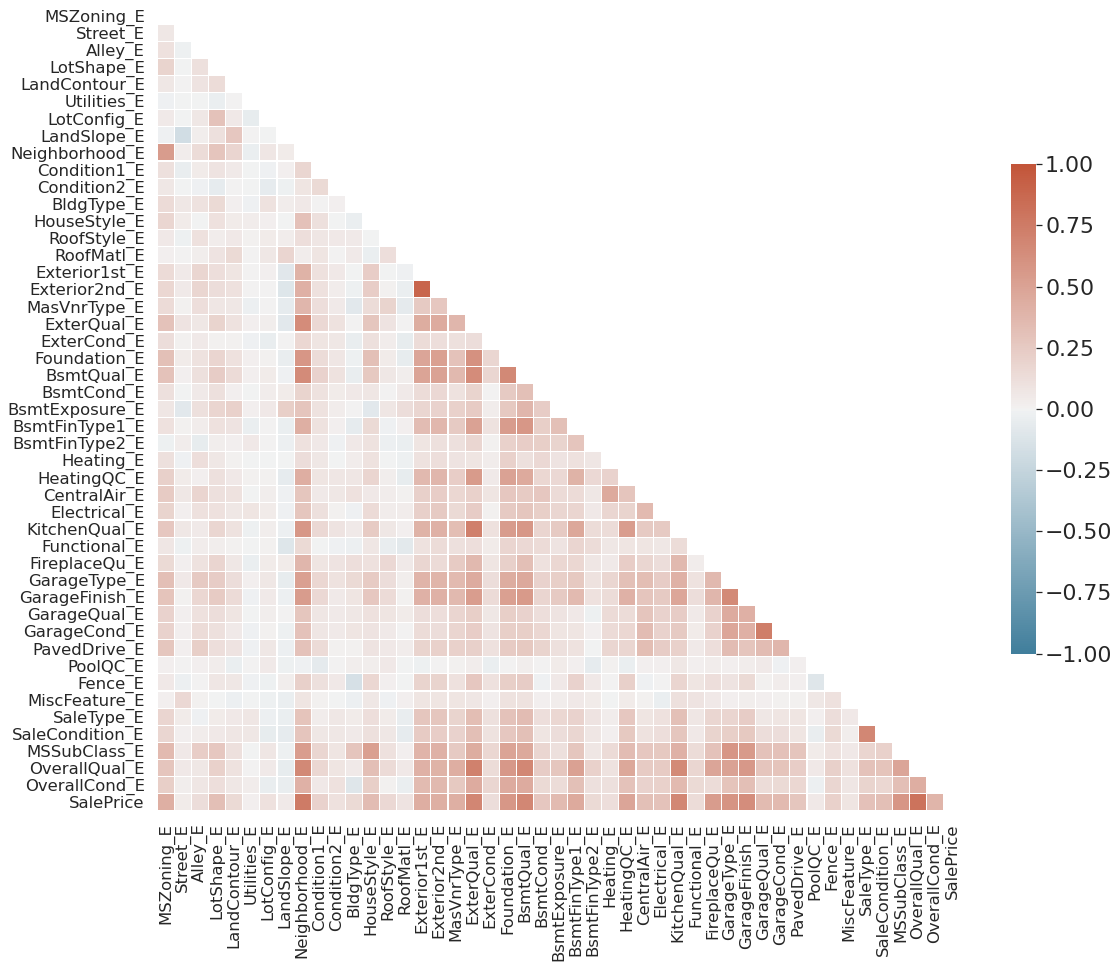

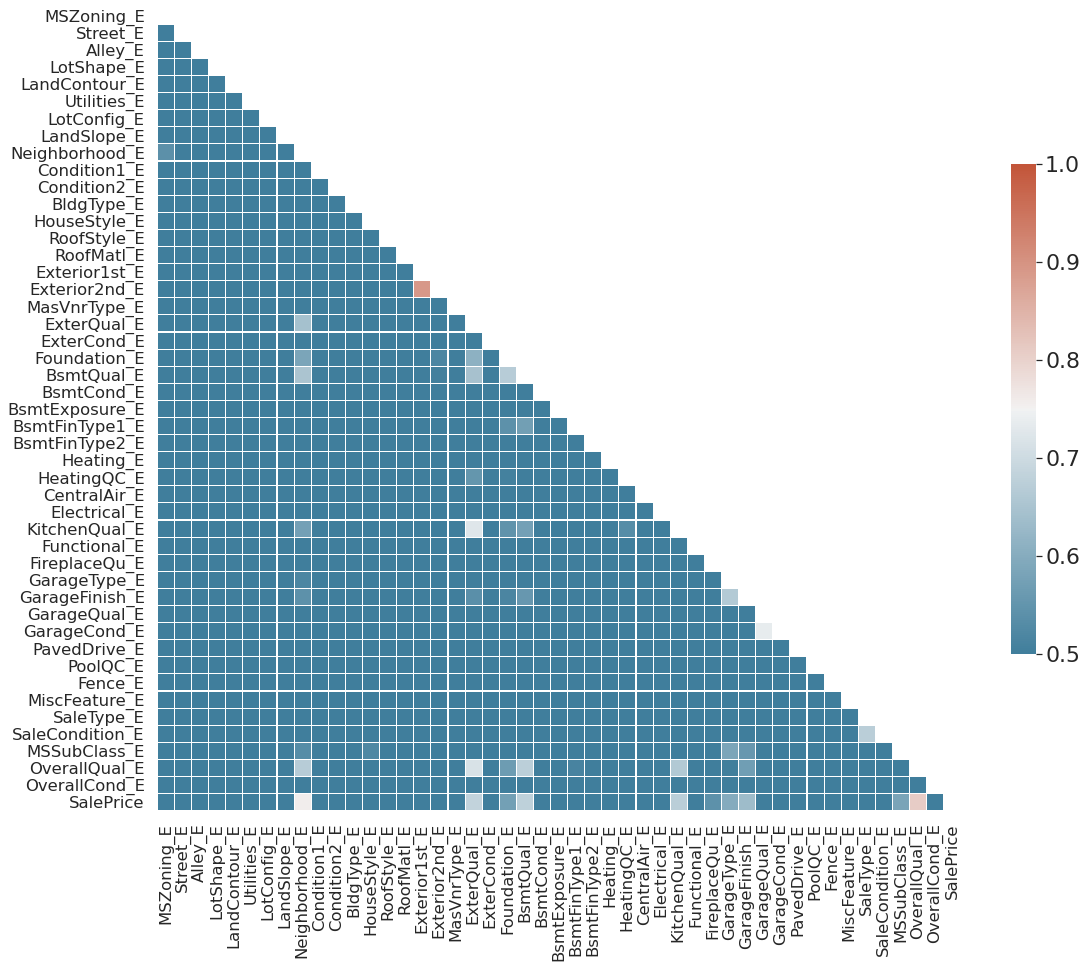

In [265]:
"""Ploting the correlation table using the Spearman correlation of the categorical variables"""
corr_cat = data[cat_encoded+["SalePrice"]].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_cat, vmax=1, vmin=-1)
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_cat, vmax=1, vmin=0.5)

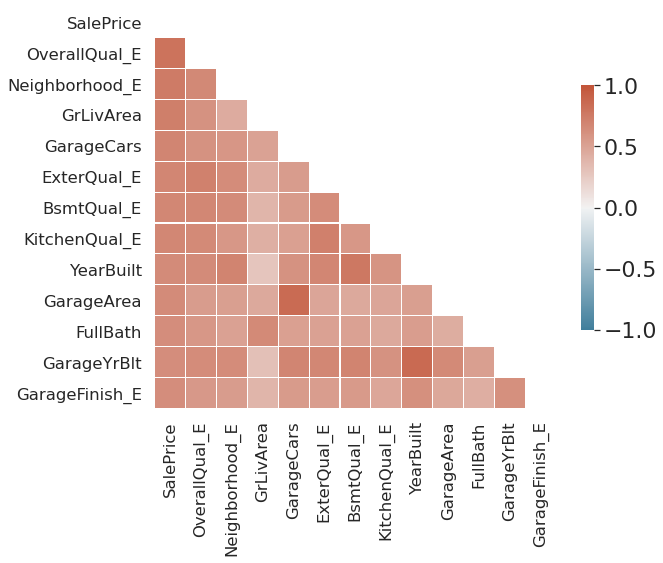

In [267]:
"""Selecting the highest correlated atributes on both the categorical and numerical columns"""
top_num = corr_num["SalePrice"].sort_values(ascending=False)[:7]
top_cat = corr_cat["SalePrice"].sort_values(ascending=False)[1:7]
top = top_cat.append(top_num).sort_values(ascending=False).index

"""Ploting their correlation"""
corr = data[top].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr, vmax=1, vmin=-1, figsize=(9, 9))

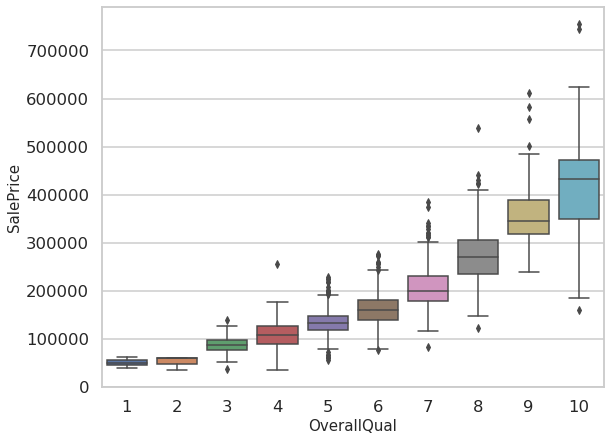

In [268]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[1], "SalePrice", data[[top[1], "SalePrice"]], legend=legend_cat[top[1][:-2]])

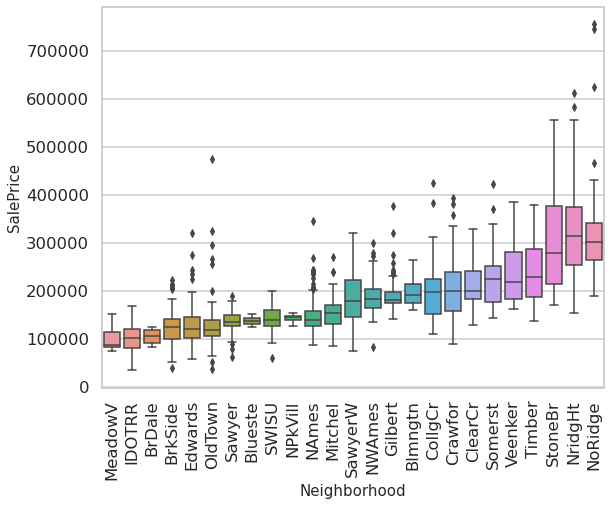

In [269]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[2], "SalePrice", data[[top[2], "SalePrice"]], legend=legend_cat[top[2][:-2]])

<Figure size 648x576 with 0 Axes>

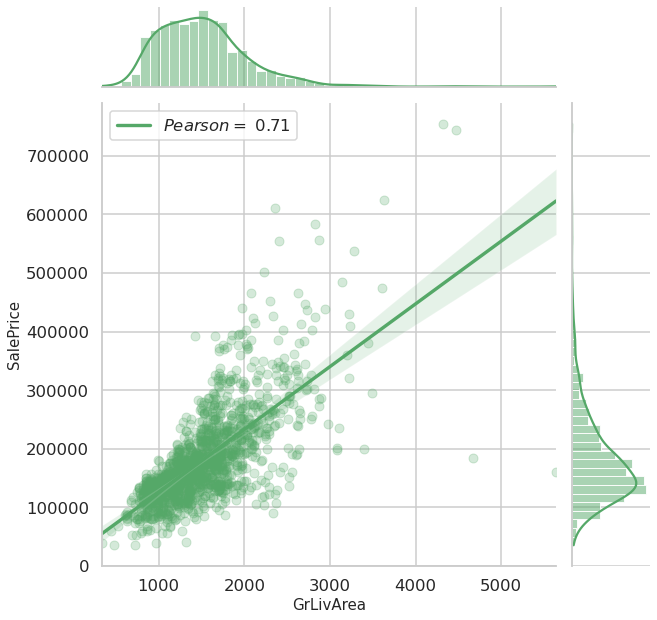

<Figure size 648x576 with 0 Axes>

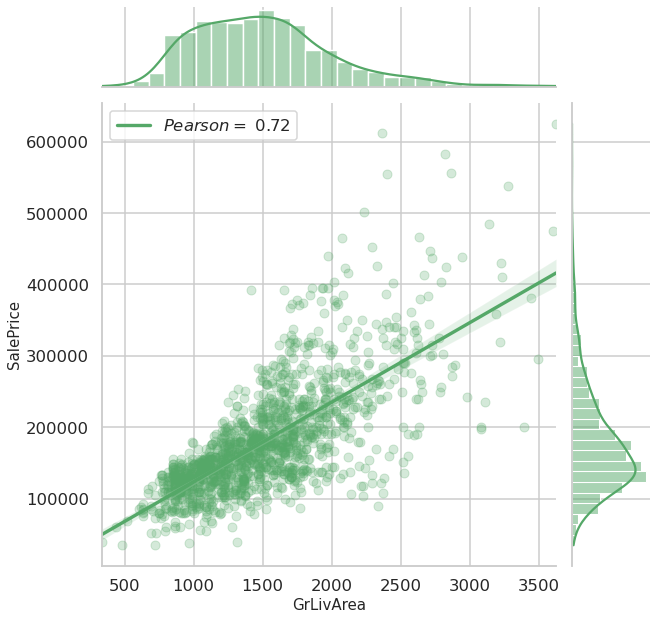

In [270]:
GrLivArea = data[[top[3], "SalePrice"]]
reg_plot(top[3], "SalePrice", GrLivArea)

data.drop(data[data.GrLivArea>4000].index, inplace = True)
GrLivArea = data[[top[3], "SalePrice"]]
reg_plot(top[3], "SalePrice", GrLivArea)

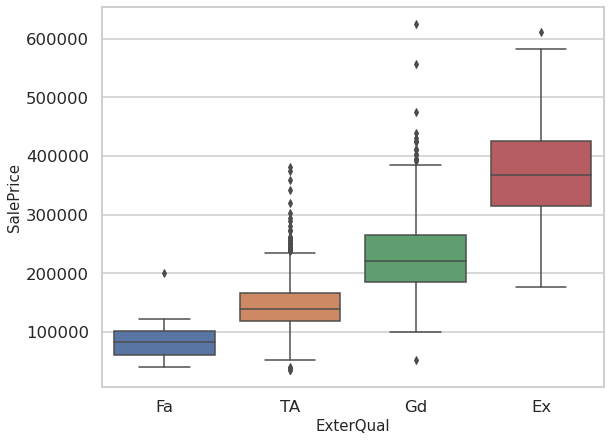

In [271]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[5], "SalePrice", data[[top[5], "SalePrice"]], legend=legend_cat[top[5][:-2]])

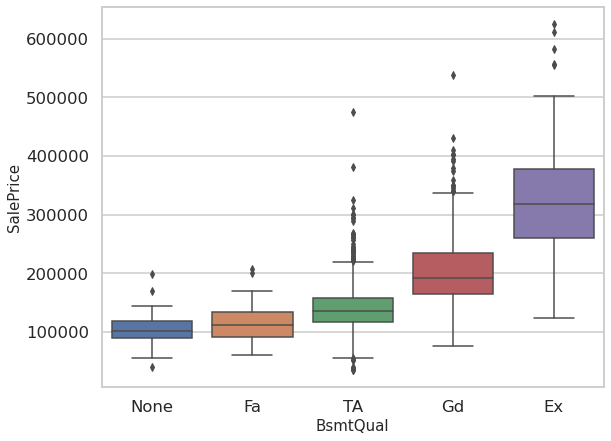

In [272]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[6], "SalePrice", data[[top[6], "SalePrice"]], legend=legend_cat[top[6][:-2]])

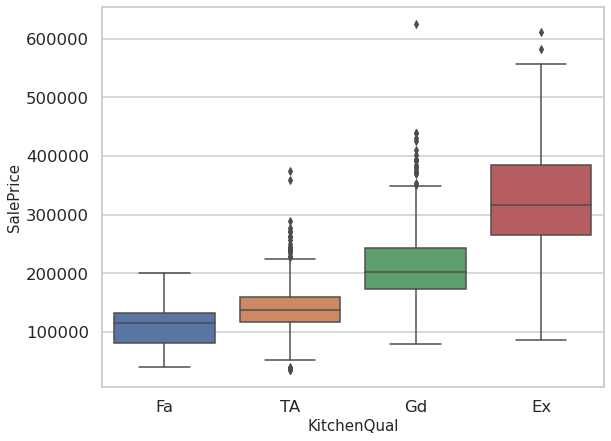

In [273]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[7], "SalePrice", data[[top[7], "SalePrice"]], legend=legend_cat[top[7][:-2]])

<Figure size 648x576 with 0 Axes>

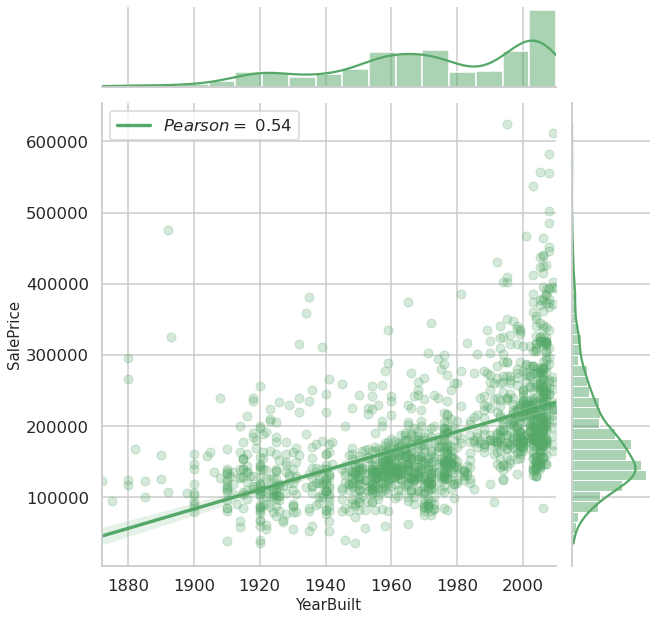

<Figure size 648x576 with 0 Axes>

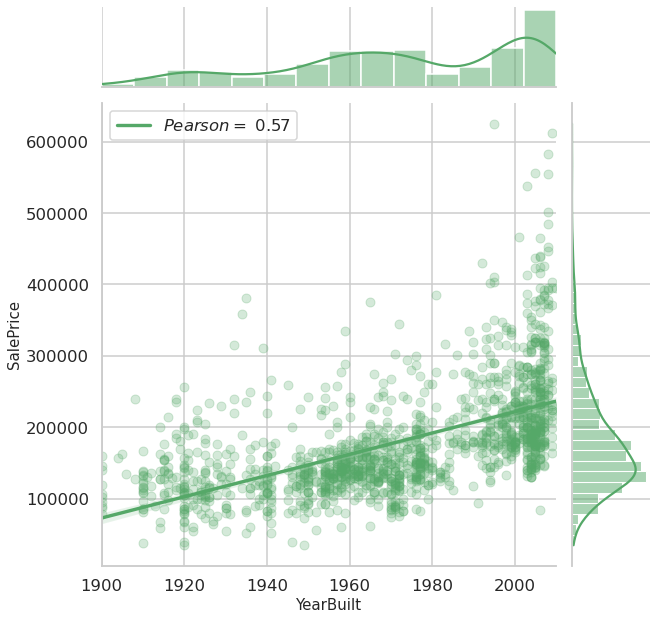

In [274]:
YearBuilt = data[[top[8], "SalePrice"]]
reg_plot(top[8], "SalePrice", YearBuilt)

data.drop(data[data.YearBuilt<1900].index, inplace = True)

YearBuilt = data[[top[8], "SalePrice"]]  
reg_plot(top[8], "SalePrice", YearBuilt)

<Figure size 648x576 with 0 Axes>

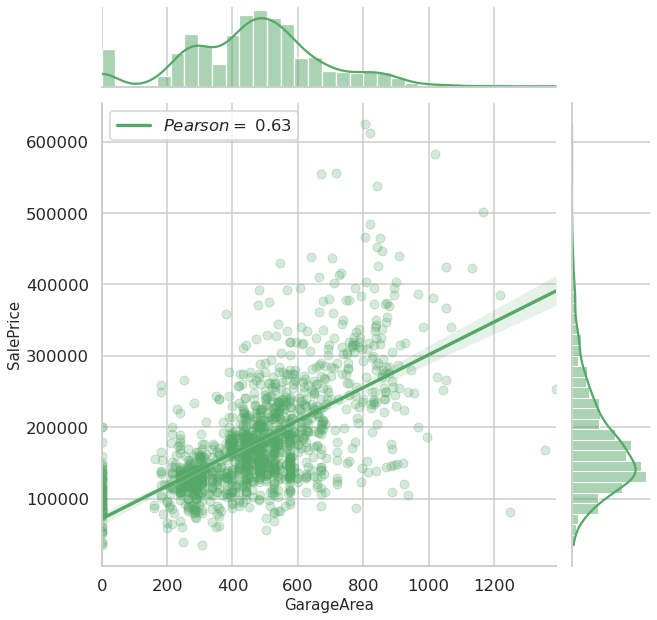

<Figure size 648x576 with 0 Axes>

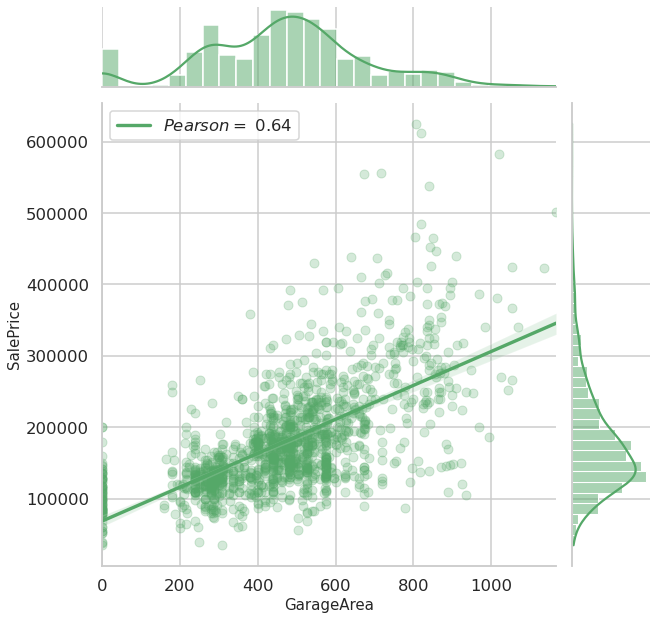

In [275]:
GarageArea = data[[top[9], "SalePrice"]]
reg_plot(top[9], "SalePrice", GarageArea)

data.drop(data[data.GarageArea>1200].index, inplace = True)
GarageArea = data[[top[9], "SalePrice"]]  
reg_plot(top[9], "SalePrice", GarageArea)

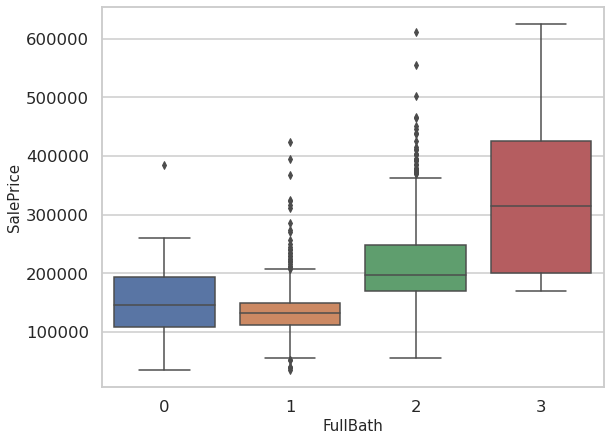

In [276]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[10], "SalePrice", data[[top[10], "SalePrice"]])

<Figure size 648x576 with 0 Axes>

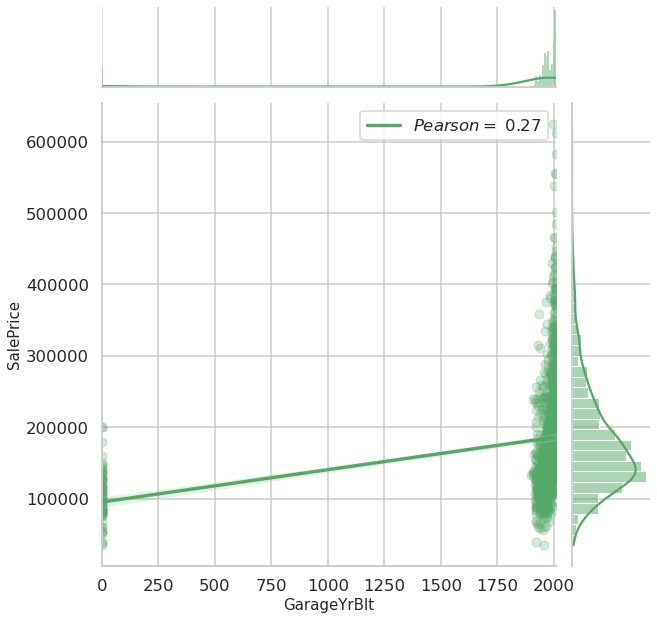

<Figure size 648x576 with 0 Axes>

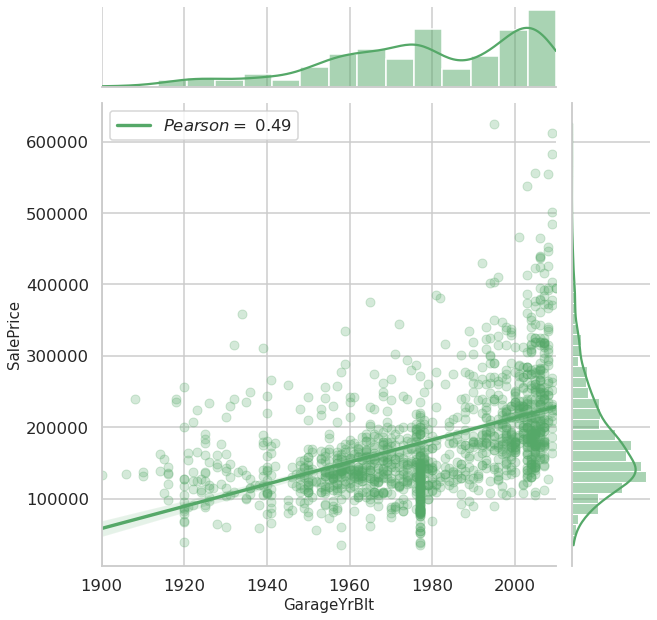

In [277]:
sns.set_theme(style="whitegrid", context="talk")
garageYrBlt = data[["GarageYrBlt", "SalePrice"]]
reg_plot("GarageYrBlt", "SalePrice", garageYrBlt)

for i in data[(data["GarageYrBlt"] == 0)].index:
    data.loc[i, "GarageYrBlt"] = data["GarageYrBlt"].median()

garageYrBlt = data[["GarageYrBlt", "SalePrice"]]    
reg_plot("GarageYrBlt", "SalePrice", garageYrBlt)

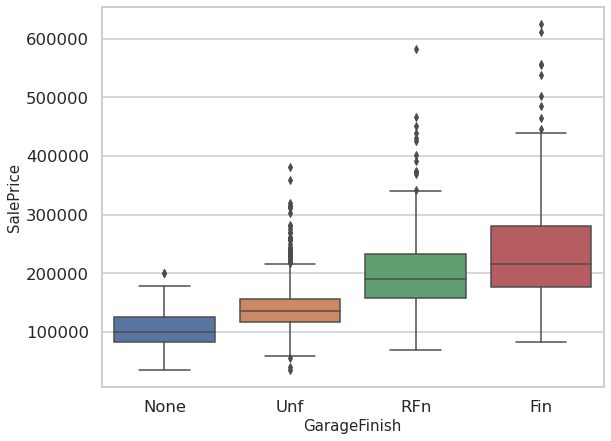

In [278]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[12], "SalePrice", data[[top[12], "SalePrice"]], legend=legend_cat[top[12][:-2]])

In [279]:
# """Ploting the most correlated columns and the dependent variable"""
# for i in range(1, top.size):
#     if top[i] == "GarageCars" or top[i] == "GarageYrBlt":
#         continue
#     elif top[i][-1] == "E":
#         sns.set_theme(style="whitegrid", context="talk")
#         box_plot(top[i], "SalePrice", data[[top[i], "SalePrice"]], legend=legend_cat[top[i][:-2]])
#     elif top[i] == "FullBath":
#         box_plot(top[i], "SalePrice", data[[top[i], "SalePrice"]])
#     else:
#         reg_plot(top[i], "SalePrice", data[[top[i], "SalePrice"]])


Aqui a gente pode ver algumas correlações positivas muito for fortes entre variáveis numéricas. Muitas delas são bem óbvias, como a correlação forte entre GarageArea e GarageCars, uma vez que quanto mais carros couberem na garagem, maior será sua área. Há também uma correlação entre TotRmsAbvGrd e GrLivArea, novamente, quanto mais salas, maior a area total de um edificio tente a ter. O mesmo pode ser observado entre a correlação do 1stFlrSF e TotalBsmtSF, já que o basement costuma ter a mesma area da casa.

Partindo para alumas correlações mais descritivas dos dados, nós temos a relação entre o GarageYrBlt e as GarageCars, algo que pode ser interessante de se visualizar.


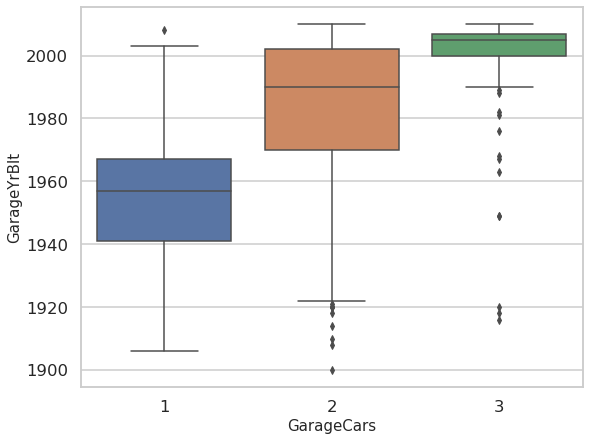

In [280]:
"""Ploting some interesting discoveries in the data"""

sns.set_theme(style="whitegrid", context="talk")
box_plot("GarageCars", "GarageYrBlt", data[(data.GarageYrBlt > 0) & (data.GarageCars > 0) & (data.GarageCars < 4)])

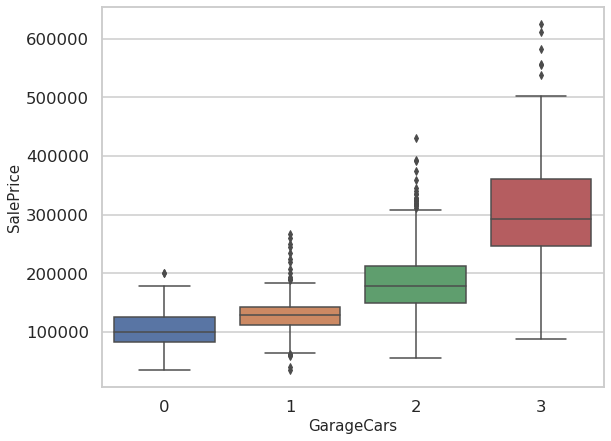

In [281]:
sns.set_theme(style="whitegrid", context="talk")
box_plot("GarageCars", "SalePrice", data[(data.GarageCars < 4)])

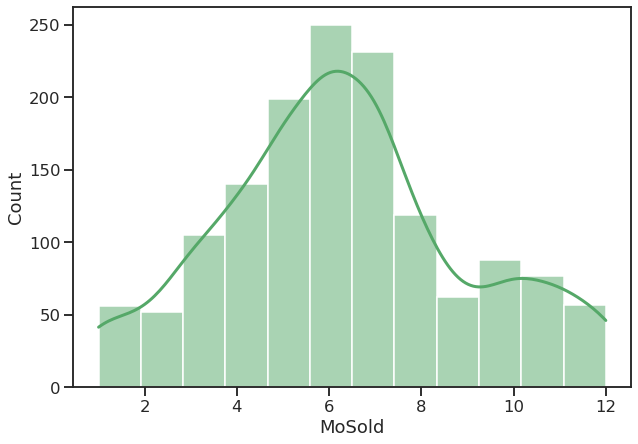

In [282]:
plot_dist(data["MoSold"], bins=12)

In [283]:
# # # If the P-Value of the Shapiro-Wilk Test is greater than 0.05, we assume a normal distribution
# def shapiro_wilk(data, numerical):
#     not_passed = []
#     passed = []    
#     for column in numerical:
#         p_value = stats.shapiro(data[column])[1]
#         if p_value >= 0.05:
#             passed.append((column, p_value))
#         else:
#             not_passed.append((column, p_value))
#     return passed, not_passed

# passed, not_passed = shapiro_wilk(data, numerical)

# print("This columns passed:")
# for column in passed:
#     print(column) 
# print("This columns did not passed:")
# for column in not_passed:
#     print(column) 
    

Kurtosis: 3.9626988199839617
Skewness: 1.5671940226687435


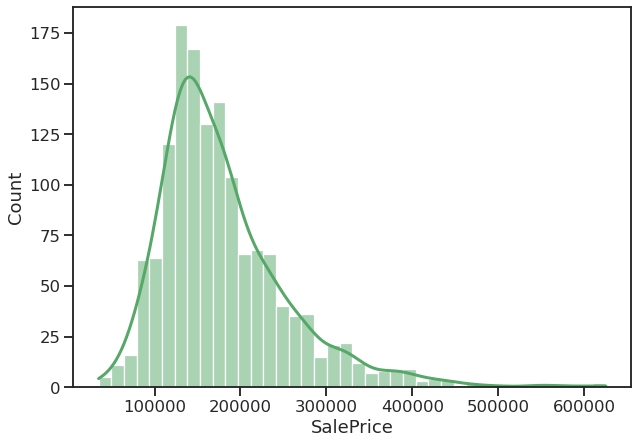

In [284]:
"""Ploting the distribution on SalePrice, as well as its Skewness and Kurtosis"""
plot_dist(data["SalePrice"])
print("Kurtosis:", data["SalePrice"].kurt())
print("Skewness:", data["SalePrice"].skew())

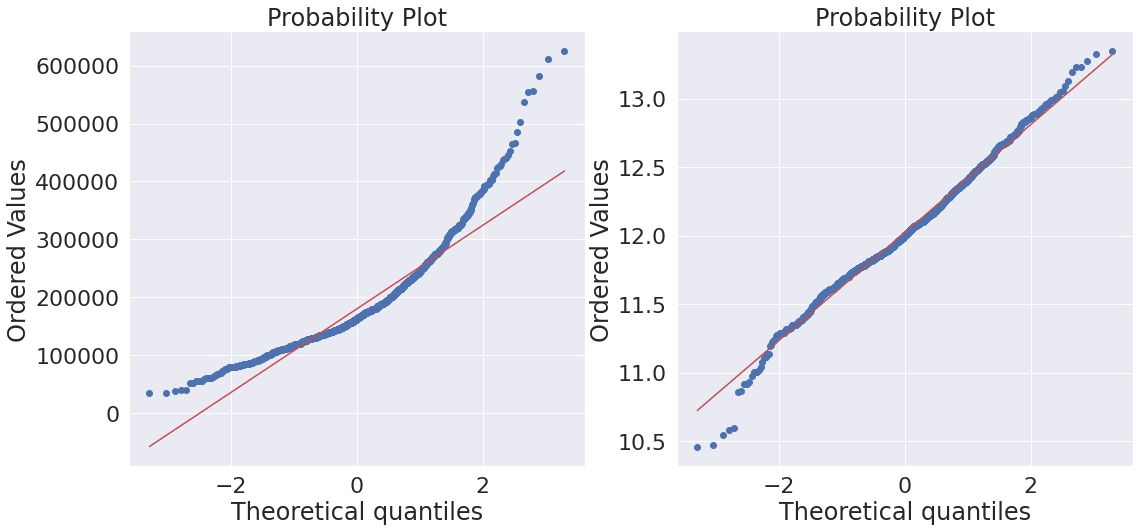

In [285]:
"""Checking the normality of the dependent variable. As we can see, the Log will work just fine"""
f,ax = plt.subplots(1,2,figsize=(18,8))
stats.probplot(np.log(data["SalePrice"]), plot=ax[1])
stats.probplot(data["SalePrice"],plot=ax[0])
plt.show()

data["SalePrice" + "_log"] = np.log1p(data["SalePrice"])

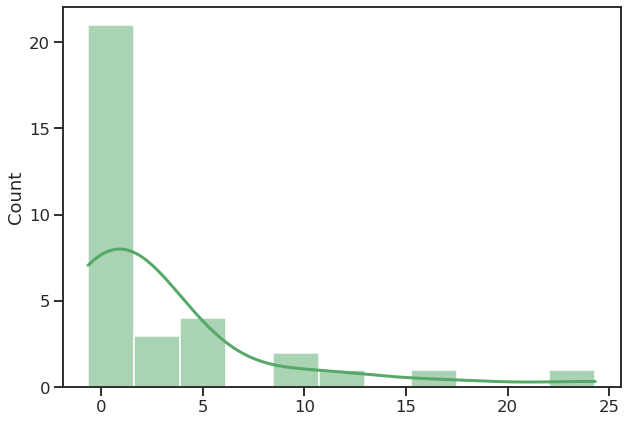

In [286]:
"""Plot the distribution of the skewness, the farther from zero, the less simetric the distribution of data is"""

skewness = data[numerical].skew()
skewness.sort_values(inplace=True, ascending=False)
plot_dist(skewness)

/opt/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


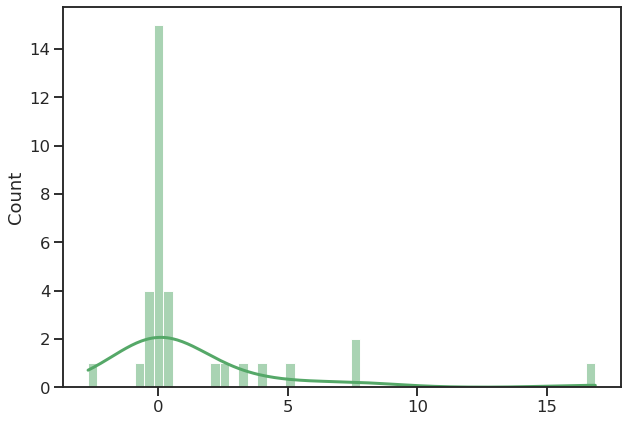

In [287]:
"""Performing data prossessing to mitigate the impacts of the lack of simetry on the distribution of values"""

scaler = PowerTransformer()
scaler.fit(data[numerical])
data_num_scaled = scaler.transform(data[numerical])
data_num_scaled = pd.DataFrame(data = data_num_scaled, columns = data[numerical].columns, index = data[numerical].index)
skewness_scaled = data_num_scaled.skew()
plot_dist(skewness_scaled)

In [288]:
"""The Series containing the skewness, we can see that PoolArea has the worst skewness"""
skewness_scaled.sort_values(ascending=False)

PoolArea         16.875969
LowQualFinSF      7.718516
3SsnPorch         7.547802
MiscVal           5.080353
BsmtHalfBath      3.849562
ScreenPorch       3.097426
BsmtFinSF2        2.396334
EnclosedPorch     2.077523
HalfBath          0.527580
MasVnrArea        0.416233
BsmtFullBath      0.346333
2ndFlrSF          0.304715
WoodDeckSF        0.133149
BedroomAbvGr      0.127645
YrSold            0.095100
Fireplaces        0.080506
LotArea           0.036113
TotRmsAbvGrd      0.002687
1stFlrSF         -0.000044
GrLivArea        -0.001041
OpenPorchSF      -0.014509
GarageCars       -0.032246
MoSold           -0.039063
TotalBsmtSF      -0.044176
FullBath         -0.056731
YearBuilt        -0.125828
GarageYrBlt      -0.129056
YearRemodAdd     -0.223249
BsmtUnfSF        -0.273318
GarageArea       -0.392586
BsmtFinSF1       -0.431074
LotFrontage      -0.609715
KitchenAbvGr     -2.712911
dtype: float64

16.87596925968943
[  0 512 648 576 519 738]


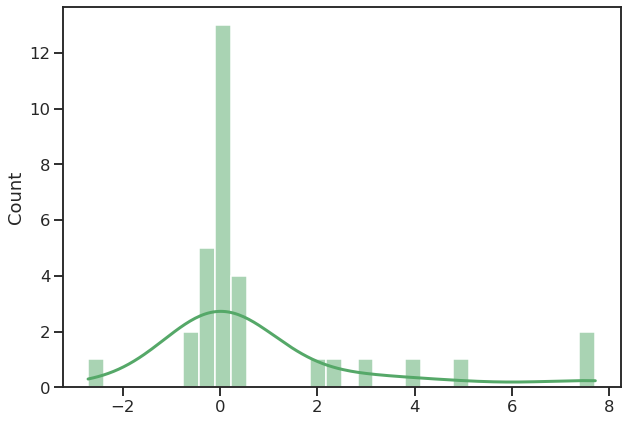

In [289]:
"""We drop the PoolArea column, once it has only 7 records with values. 
Note that we don't lose the information of having a pool because the PoolQC column"""

print(skewness_scaled.sort_values()[-1])
print(data["PoolArea"].unique())
numerical.remove("PoolArea")
plot_dist(data_num_scaled[numerical].skew())

In [290]:
# passed, not_passed = shapiro_wilk(data_num_scaled, numerical)

# print("This columns passed:")
# for column in passed:
#     print(column) 
# print("This columns did not passed:")
# for column in not_passed:
#     print(column) 

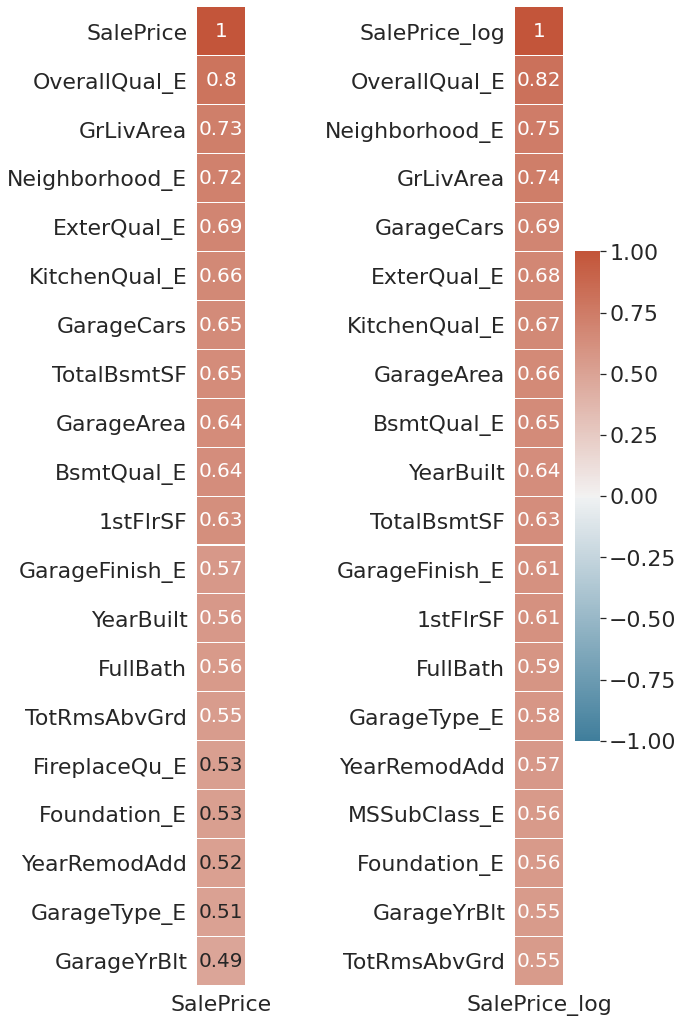

In [291]:
"""Comparing the correlation before and after the data transformations"""

frame = [data_num_scaled, data[cat_encoded + ["SalePrice", "SalePrice_log"]]]
data_concat = pd.concat(frame, axis=1)

corr_SalePrice = data[numerical + cat_encoded + ["SalePrice"]].corr()
corr_SalePrice_log = data_concat[numerical + cat_encoded + ["SalePrice_log"]].corr()

f, ax = plt.subplots(1, 2, figsize=(9, 18))
triang_corr_plot(corr_SalePrice[["SalePrice"]].sort_values(by=['SalePrice'],ascending=False).head(20), 
                 vmax=1, vmin=-1, mask=False, annot=True, annot_kws={"size": 20}, 
                 square=True, ax=ax[0], cbar=False, figsize=(0, 0))

triang_corr_plot(corr_SalePrice_log[["SalePrice_log"]].sort_values(by=['SalePrice_log'],ascending=False).head(20), 
                 vmax=1, vmin=-1, mask=False, annot=True, annot_kws={"size": 20}, 
                 square=True, ax=ax[1], figsize=(0, 0))

Once we have all the NaN values dealt with, we can proceed to split the data in dependent variable and independent variables.
I'll use the conventional notation ```X``` for the independent variables and ```y``` to the dependent.


In [292]:
X = data_concat.copy()
X.drop(labels=["SalePrice", "SalePrice_log"], axis="columns", inplace=True)
X[cat_encoded] = X[cat_encoded].astype('int64')
X = pd.get_dummies(X, columns=cat_encoded)
X.head(10)

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0     0.307932 -0.131037   1.152204      0.909949    1.226017    0.797166   
1     0.682264  0.117814  -0.001210     -0.615724   -0.822695    1.018448   
2     0.384324  0.428932   1.055793      0.837904    1.188596    0.564049   
3     0.178703  0.107605  -1.697602     -0.858019   -0.822695    0.124613   
4     0.779136  0.897733   1.008296      0.697962    1.330179    0.748661   
5     0.803179  0.877431   0.688640      0.371113   -0.822695    0.820877   
6     0.559523  0.214086   1.201128      1.058322    1.215896    1.265713   
7    -1.830068  0.271178  -0.111272     -0.740466    1.264018    0.928273   
8    -0.060657 -0.754523  -1.348873     -1.485606   -0.822695   -1.366044   
9    -0.087849 -0.383236  -1.151883     -1.485606   -0.822695    0.921878   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  OverallQual_E_10  \
0   -0.362767  -0.877997    -0.427455 -0.800852  ...                 0   
1   -0.362767  -0.424407     0.534590  0.437987  ...                 0   
2   -0.362767  -0.038231    -0.270847 -0.570915  ...                 0   
3   -0.362767   0.192941    -0.676732 -0.431834  ...                 0   
4   -0.362767   0.087217     0.264373  0.127277  ...                 0   
5   -0.362767  -1.304802    -0.576311 -1.032518  ...                 0   
6   -0.362767  -0.331577     1.477426  1.378975  ...                 0   
7    2.741324  -0.635695     0.175498  0.019524  ...                 0   
8   -0.362767   0.916115    -0.193326 -0.235471  ...                 0   
9   -0.362767  -0.919332    -0.099514 -0.068178  ...                 0   

   OverallCond_E_1  OverallCond_E_2  OverallCond_E_3  OverallCond_E_4  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   
5                0                0                0                0   
6                0                0                0                0   
7                0                0                0                0   
8                0                0                0                0   
9                0                0                0                0   

   OverallCond_E_5  OverallCond_E_6  OverallCond_E_7  OverallCond_E_8  \
0                0                0                0                1   
1                0                1                0                0   
2                0                0                0                1   
3                0                0                0                1   
4                0                0                0                1   
5                0                0                0                1   
6                0                0                0                1   
7                1                0                0                0   
8                0                0                0                1   
9                1                0                0                0   

   OverallCond_E_9  
0                0  
1                0  
2                0  
3                0  
4                0  
5                0  
6                0  
7                0  
8                0  
9                0  

[10 rows x 330 columns]

In [293]:
X_linear = data_concat.copy()
X_linear.drop(labels=["SalePrice", "SalePrice_log"], axis="columns", inplace=True)
X_linear[cat_encoded] = X_linear[cat_encoded].astype('int64')
X_linear.head()

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0     0.307932 -0.131037   1.152204      0.909949    1.226017    0.797166   
1     0.682264  0.117814  -0.001210     -0.615724   -0.822695    1.018448   
2     0.384324  0.428932   1.055793      0.837904    1.188596    0.564049   
3     0.178703  0.107605  -1.697602     -0.858019   -0.822695    0.124613   
4     0.779136  0.897733   1.008296      0.697962    1.330179    0.748661   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  GarageCond_E  \
0   -0.362767  -0.877997    -0.427455 -0.800852  ...             6   
1   -0.362767  -0.424407     0.534590  0.437987  ...             6   
2   -0.362767  -0.038231    -0.270847 -0.570915  ...             6   
3   -0.362767   0.192941    -0.676732 -0.431834  ...             6   
4   -0.362767   0.087217     0.264373  0.127277  ...             6   

   PavedDrive_E  PoolQC_E  Fence_E  MiscFeature_E  SaleType_E  \
0             3         1        5              4           5   
1             3         1        5              4           5   
2             3         1        5              4           5   
3             3         1        5              4           5   
4             3         1        5              4           5   

   SaleCondition_E  MSSubClass_E  OverallQual_E  OverallCond_E  
0                5            15              7              8  
1                5            12              6              6  
2                5            15              7              8  
3                2            10              7              8  
4                5            15              8              8  

[5 rows x 79 columns]

In [294]:
y = data_concat["SalePrice_log"].copy()
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice_log, dtype: float64

In [295]:
# 42, because it is the answer
seed = 42 

# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=seed)

(1077,)
(359,)


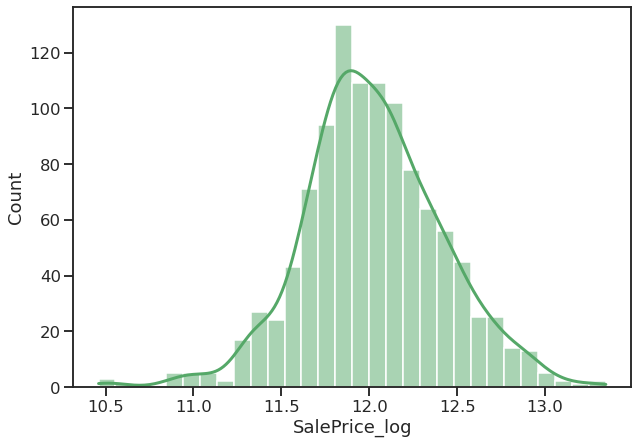

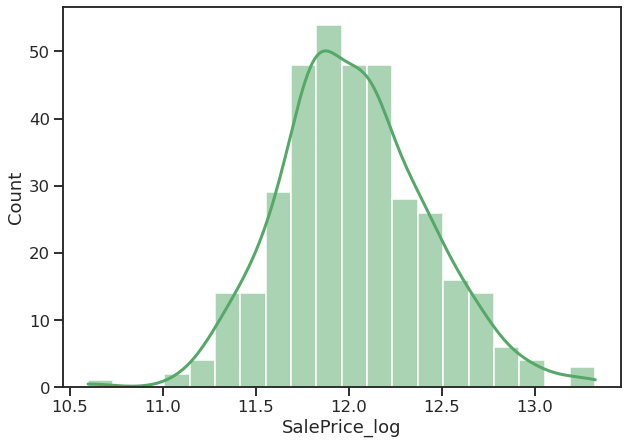

In [296]:
print(y_train.shape)
plot_dist(y_train)
print(y_test.shape)
plot_dist(y_test)

In [297]:


# n_jobs is the the number of jobs to run in parallel.
# n_jobs = -1 means using all processors.

randon_forest = RandomForestRegressor(n_estimators = 100, random_state = seed, n_jobs = -1)
adaboost = AdaBoostRegressor(random_state = seed)
gradient_boost = GradientBoostingRegressor(random_state = seed) 
extreme_gradient_boost = XGBRegressor(n_estimators = 100, random_state = seed)


linear_regression = LinearRegression() 
ridge_regression = Ridge(random_state = seed) ##
lasso_regression = Lasso(random_state = seed) ##
elastic_net = ElasticNet(random_state = seed)
bayesian_ridge = BayesianRidge(n_iter = 100)

sv_regression = SVR()
knn = KNeighborsRegressor(n_jobs = -1)

tree_models_names = ["RandForest", "AdaBoost", "GradBoost", "XGBoost"]
tree_models = [randon_forest, adaboost, gradient_boost, extreme_gradient_boost]
 
linear_models_names = ["RidgeReg", "LassoReg", "ElasticNet", "BayesianRidge"]
linear_models = [ridge_regression, lasso_regression, elastic_net, bayesian_ridge]
# "LinReg", linear_regression,

other_models_names = ["SVReg", "KNN"]
other_models = [sv_regression, knn]

all_models_names = tree_models_names + linear_models_names + other_models_names
all_models = tree_models + linear_models + other_models


def train_model(model):
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    return score

def evaluate_rmse(model):
    prediction = model.predict(X_test)
    mse = mean_squared_error(prediction, y_test)
    rmse = np.sqrt(mse)
    return rmse

def cross_validation(model):
    cv_score = cross_val_score(model, X, y, cv = 10, n_jobs = -1, scoring = "neg_mean_squared_error")
    sq_cv_score = np.sqrt(-1*cv_score)
    return sq_cv_score.mean()

def train_and_evaluate(models):
    training_score = []
    evaluation_score = []
    cv_score = []
    for model in models:
        training_score.append(train_model(model))
        evaluation_score.append(evaluate_rmse(model))
        cv_score.append(cross_validation(model))

    train_score = pd.DataFrame()
    train_score["training_score"] = training_score
    train_score["rmse"] = evaluation_score
    train_score["cv_score"] = cv_score
    train_score.index = all_models_names
    return train_score

def plot_serie(data, x_label, **kwargs):
    sns.set_theme(style="whitegrid", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=(10, 7))
    sns.barplot(x=data.index, y=data.values, ax=ax1, orient="v", **kwargs)
    plt.xticks(ticks=range(0, len(data.index)), labels=data.index, rotation=90)
    sns.set(font_scale=2)
    ax1.set_xlabel(x_label)
    plt.plot()
        


In [298]:
train_score = train_and_evaluate(all_models, )
train_score.sort_values(by="cv_score")

training_score      rmse  cv_score
BayesianRidge        0.946554  0.107723  0.109613
RidgeReg             0.952796  0.111288  0.112320
GradBoost            0.961531  0.124757  0.122951
XGBoost              0.999519  0.138807  0.131214
SVReg                0.960780  0.129111  0.131995
RandForest           0.980081  0.136179  0.138598
KNN                  0.873299  0.163874  0.167441
AdaBoost             0.845898  0.180127  0.184187
LassoReg             0.000000  0.394331  0.393525
ElasticNet           0.000000  0.394331  0.393525

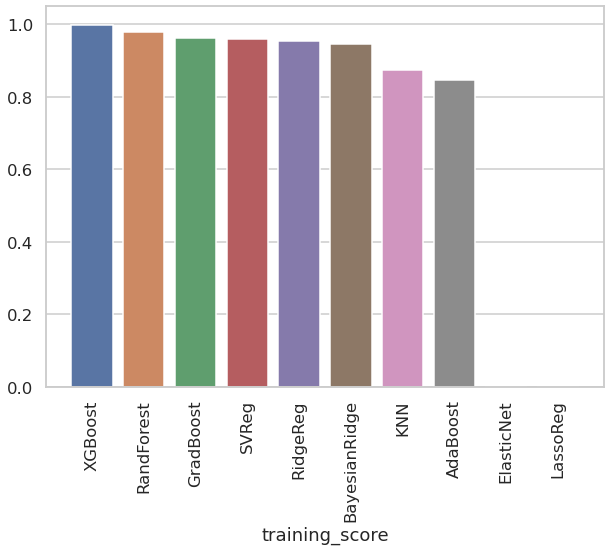

In [299]:
plot_serie(train_score["training_score"].sort_values(ascending=False), "training_score")

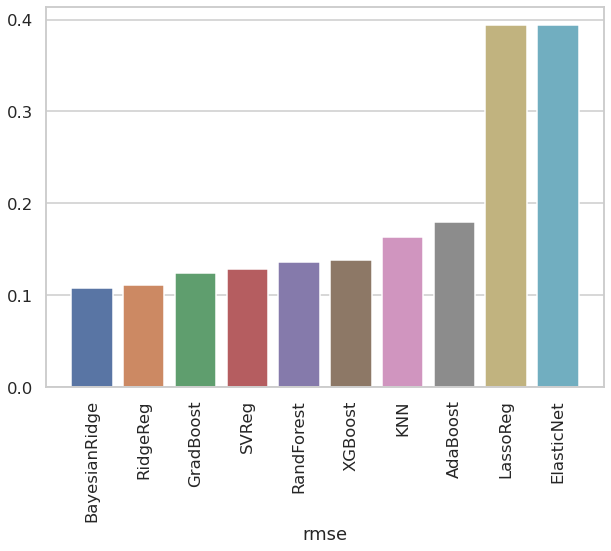

In [300]:
plot_serie(train_score["rmse"].sort_values(), "rmse")

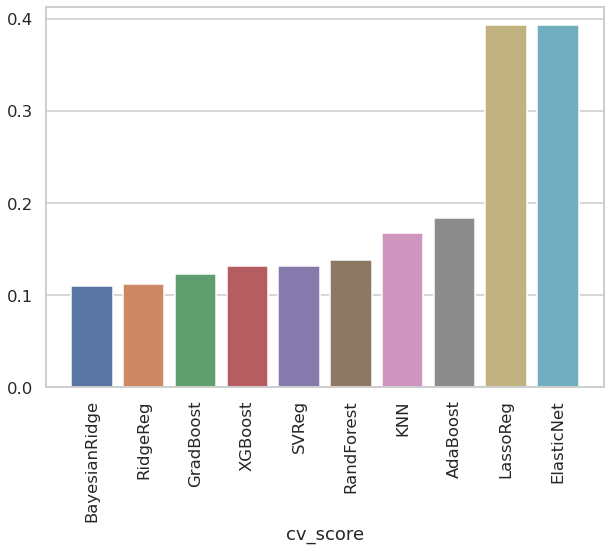

In [301]:
plot_serie(train_score["cv_score"].sort_values(), "cv_score")

In [302]:
def hyperparameters_optimization(model, param_distributions, X, y):
    dist = RandomizedSearchCV(model, param_distributions, n_iter = 100, cv = 10, verbose = 1, 
                              scoring = 'neg_root_mean_squared_error', n_jobs = -1)
    dist.fit(X, y)
    cv_results = dist.cv_results_
    best_estimator = dist.best_estimator_
    best_params = dist.best_params_ 
    best_score = -1 * dist.best_score_
    return cv_results, best_estimator, best_params, best_score

def save_experiment(model_name, data_X, y, cv_results):
    if not os.path.isdir('../experiments/' + model_name):
        os.mkdir('../experiments/' + model_name, mode=0o777, dir_fd=None)
        
    directory = '../experiments/' + model_name + "/" + datetime.datetime.now().isoformat()
    os.mkdir(directory, mode=0o777, dir_fd=None)
    os.mkdir(directory + "/data", mode=0o777, dir_fd=None)
    
    df_cv_results = pd.DataFrame(cv_results).sort_values(by="rank_test_score")
    df_cv_results.to_csv(directory + "/cv_results.csv")
    data_X.to_csv(directory + "/data/X.csv")
    y.to_csv(directory + "/data/y.csv")


Minimizes: $||y - Xw||^2_2 + alpha * ||w||^2_2$


In [303]:
model_name = "RidgeReg"
data_X = X
ridge_param_dist = {"alpha": np.linspace(0.00001, 11, num=2000),
                    "solver": ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
                    'random_state': [seed]}

cv_results, ridge_best_estimator, ridge_best_params, ridge_best_score = hyperparameters_optimization(ridge_regression, ridge_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(ridge_best_params, ridge_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished


RidgeReg best params:{'solver': 'svd', 'random_state': 42, 'alpha': 5.865937633816909} 
Best_score:0.10951900


In [304]:
model_name = "LassoReg"
data_X = X

lasso_param_dist = {"alpha": np.linspace(0.00001, 0.001, num=2000),
                    'random_state': [seed]}

cv_results, lasso_best_estimator, lasso_best_params, lasso_best_score = hyperparameters_optimization(lasso_regression, lasso_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(lasso_best_params, lasso_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:   33.0s


LassoReg best params:{'random_state': 42, 'alpha': 0.0003086343171585793} 
Best_score:0.10758283


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   40.5s finished


In [305]:
model_name = "ElasticNet"
data_X = X

elastic_net_param_dist = {"alpha": np.linspace(0.00001, 0.001, num=2000),
                          'l1_ratio': np.linspace(0.001, 1, num=2000),
                          'random_state': [seed]}

cv_results, elastic_net_best_estimator, elastic_net_best_params, elastic_net_best_score = hyperparameters_optimization(elastic_net, elastic_net_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(elastic_net_best_params, elastic_net_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


ElasticNet best params:{'random_state': 42, 'l1_ratio': 0.5797103551775887, 'alpha': 0.0005602201100550275} 
Best_score:0.10767283


In [306]:
model_name = "BayesianRidge"
data_X = X

bayesian_ridge_param_dist = {"alpha_1": np.linspace(1e-06, 9e-06, num=2000),
                             "alpha_2": np.linspace(1e-06, 9e-06, num=2000),
                             "lambda_1": np.linspace(4e-06, 7e-06, num=2000),
                             "lambda_2": np.linspace(1e-08, 4e-07, num=2000)}

cv_results, bayesian_ridge_best_estimator, bayesian_ridge_best_params, bayesian_ridge_best_score = hyperparameters_optimization(bayesian_ridge, bayesian_ridge_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(bayesian_ridge_best_params, bayesian_ridge_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.4s finished


BayesianRidge best params:{'lambda_2': 3.72296148074037e-07, 'lambda_1': 4.964982491245623e-06, 'alpha_2': 1.3401700850425212e-06, 'alpha_1': 5.65032516258129e-06} 
Best_score:0.10961270


In [307]:
model_name = "RandForest"
data_X = X

randon_forest_param_dist = {'n_estimators': np.linspace(70, 200, num=10, dtype=int), 
                            'max_depth': np.linspace(40, 100, num=60, dtype=int),
                            'min_samples_split': np.linspace(2, 7, num=5, dtype=int),
                            'min_samples_leaf': np.linspace(1, 3, num=3, dtype=int),
                            'random_state':[seed]}

cv_results, randon_forest_best_estimator, randon_forest_best_params, randon_forest_best_score = hyperparameters_optimization(randon_forest, randon_forest_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(randon_forest_best_params, randon_forest_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.5min finished


RandForest best params:{'random_state': 42, 'n_estimators': 171, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 100} 
Best_score:0.13833612


In [308]:
model_name = "AdaBoost"
data_X = X

adaboost_param_dist = {"n_estimators": np.linspace(200, 300, num=100, dtype=int), 
                       "learning_rate": np.linspace(3, 8, num=2000),
                       "loss": ["linear", "square", "exponential"],
                       'random_state':[seed]}

cv_results, adaboost_best_estimator, adaboost_best_params, adaboost_best_score = hyperparameters_optimization(adaboost, adaboost_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(adaboost_best_params, adaboost_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 12.4min finished


AdaBoost best params:{'random_state': 42, 'n_estimators': 288, 'loss': 'exponential', 'learning_rate': 4.878439219609804} 
Best_score:0.16810400


In [309]:
model_name = "GradBoost"
data_X = X

gradient_boost_param_dist = {"n_estimators": np.linspace(500, 1000, num=5, dtype=int), 
                             "learning_rate": np.linspace(0.0001, 1, num=2000),
                             "subsample": np.linspace(0.0001, 1, num=2000),
                             "min_samples_split": np.linspace(2, 7, num=5, dtype=int),
                             "min_samples_leaf": np.linspace(1, 3, num=3, dtype=int),
                             "max_depth": np.linspace(45, 65, num=20, dtype=int),
                             "random_state":[seed]}

cv_results, gradient_boost_best_estimator, gradient_boost_best_params, gradient_boost_best_score = hyperparameters_optimization(gradient_boost, gradient_boost_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(gradient_boost_best_params, gradient_boost_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 61.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 81.8min finished


GradBoost best params:{'subsample': 0.2917166583291646, 'random_state': 42, 'n_estimators': 625, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 57, 'learning_rate': 0.04761900950475238} 
Best_score:0.11834719


GradBoost best params:{'subsample': 0.700443171585793, 'random_state': 42, 'n_estimators': 158, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'learning_rate': 0.5553720860430216} 
Best_score:0.17589430

GradBoost best params:{'subsample': 0.8755289644822412, 'random_state': 42, 'n_estimators': 223, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 59, 'learning_rate': 0.01910855427713857} 
Best_score:0.14245270

GradBoost best params:{'subsample': 0.5933669834917459, 'random_state': 42, 'n_estimators': 91, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 46, 'learning_rate': 0.03311485742871436} 
Best_score:0.13760960

GradBoost best params:{'subsample': 0.15866343171585792, 'random_state': 42, 'n_estimators': 198, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 47, 'learning_rate': 0.03761500750375188} 
Best_score:0.12880182

GradBoost best params:{'subsample': 0.1701680340170085, 'random_state': 42, 'n_estimators': 466, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 59, 'learning_rate': 0.028111205602801403} 
Best_score:0.12672455

GradBoost best params:{'subsample': 0.10914362181090546, 'random_state': 42, 'n_estimators': 875, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 54, 'learning_rate': 0.011604602301150575} 
Best_score:0.12414593

In [310]:
model_name = "XGBoost"
data_X = X

extreme_gradient_boost_param_dist = {"min_child_weight": np.linspace(1, 8, num=5, dtype=int), 
                                     'gamma': np.linspace(0.0001, 0.03, num=2000),
                                     "learning_rate": np.linspace(0.001, 0.3, num=2000),
                                     "subsample": np.linspace(0.1, 1, num=2000),
                                     'colsample_bytree': np.linspace(0.1, 1, num=2000),
                                     "max_depth": np.linspace(40, 60, num=20, dtype=int),
                                     "reg_alpha": [0.4640], 
                                     "reg_lambda": [0.8571],
                                     "random_state":[seed]}

xgb_opt = XGBRegressor(silent = 1, nthread = -1, predictor="gpu_predictor")

cv_results, extreme_gradient_boost_best_estimator, extreme_gradient_boost_best_params, extreme_gradient_boost_best_score = hyperparameters_optimization(extreme_gradient_boost, extreme_gradient_boost_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(extreme_gradient_boost_best_params, extreme_gradient_boost_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 17.5min finished


XGBoost best params:{'subsample': 0.8428714357178589, 'reg_lambda': 0.8571, 'reg_alpha': 0.464, 'random_state': 42, 'min_child_weight': 6, 'max_depth': 54, 'learning_rate': 0.09224062031015508, 'gamma': 0.009403551775887944, 'colsample_bytree': 0.7262631315657829} 
Best_score:0.12205847


XGBoost best params:{'subsample': 0.7919167583791896, 'reg_lambda': 0.8571, 'reg_alpha': 0.464, 'random_state': 42, 'min_child_weight': 5, 'max_depth': 43, 'learning_rate': 0.29, 'gamma': 0.148, 'colsample_bytree': 0.9894957978989495} 
Best_score:0.13958695

XGBoost best params:{'subsample': 0.8704481740870436, 'reg_lambda': 0.8571, 'reg_alpha': 0.464, 'random_state': 42, 'min_child_weight': 7, 'max_depth': 57, 'learning_rate': 0.2763621810905452, 'gamma': 0.048644322161080535, 'colsample_bytree': 0.5273109054527264} 
Best_score:0.13230833

XGBoost best params:{'subsample': 0.6463585292646323, 'reg_lambda': 0.8571, 'reg_alpha': 0.464, 'random_state': 42, 'min_child_weight': 6, 'max_depth': 53, 'learning_rate': 0.13232666333166584, 'gamma': 0.01935967983991996, 'colsample_bytree': 0.7939175587793897} 
Best_score:0.12696853

XGBoost best params:{'subsample': 0.9248124062031016, 'reg_lambda': 0.8571, 'reg_alpha': 0.464, 'random_state': 42, 'min_child_weight': 6, 'max_depth': 45, 'learning_rate': 0.0861080540270135, 'gamma': 0.022685792896448224, 'colsample_bytree': 0.6906953476738369} 
Best_score:0.12630516

XGBoost best params:{'subsample': 0.8046023011505753, 'reg_lambda': 0.8571, 'reg_alpha': 0.464, 'random_state': 42, 'min_child_weight': 4, 'max_depth': 46, 'learning_rate': 0.0868, 'gamma': 0.026606853426713355, 'colsample_bytree': 0.8172086043021511} 
Best_score:0.12786935

XGBoost best params:{'subsample': 0.7901950975487744, 'reg_lambda': 0.8571, 'reg_alpha': 0.464, 'random_state': 42, 'min_child_weight': 2, 'max_depth': 44, 'learning_rate': 0.1433951975987994, 'gamma': 0.007862931465732866, 'colsample_bytree': 0.635767883941971} 
Best_score:0.12746437

In [311]:
model_name = "SVReg"
data_X = X

sv_regression_param_dist = {"kernel": ["rbf"],
                            "C": np.linspace(5, 10, num=5, dtype=int),
                            "gamma": np.linspace(0.0001, 0.01, num=2000),
                            "epsilon": np.linspace(0.001, 0.04, num=2000)}

cv_results, sv_regression_best_estimator, sv_regression_best_params, sv_regression_best_score = hyperparameters_optimization(sv_regression, sv_regression_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(sv_regression_best_params, sv_regression_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished


SVReg best params:{'kernel': 'rbf', 'gamma': 0.0008428714357178591, 'epsilon': 0.03553226613306653, 'C': 10} 
Best_score:0.10784529


SVReg best params:{'kernel': 'rbf', 'gamma': 0.001625662831415708, 'epsilon': 0.013666433216608303, 'C': 7} 
Best_score:0.11904999

SVReg best params:{'kernel': 'rbf', 'gamma': 0.0014916458229114558, 'epsilon': 0.021777888944472235, 'C': 8} 
Best_score:0.11941207

SVReg best params:{'kernel': 'rbf', 'gamma': 0.001496598299149575, 'epsilon': 0.00983791895947974, 'C': 5} 
Best_score:0.11934013

In [312]:
model_name = "KNN"
data_X = X

knn_param_dist = {"n_neighbors": np.linspace(5, 35, num=30, dtype=int),
                  "algorithm": ["ball_tree", "kd_tree"],
                  "leaf_size": np.linspace(15, 45, num=30, dtype=int),
                  "weights": ["uniform", "distance"]}

cv_results, knn_best_estimator, knn_best_params, knn_best_score = hyperparameters_optimization(knn, knn_param_dist, data_X, y)
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(knn_best_params, knn_best_score))

save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   24.1s


KNN best params:{'weights': 'distance', 'n_neighbors': 7, 'leaf_size': 40, 'algorithm': 'kd_tree'} 
Best_score:0.16608896


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   28.3s finished


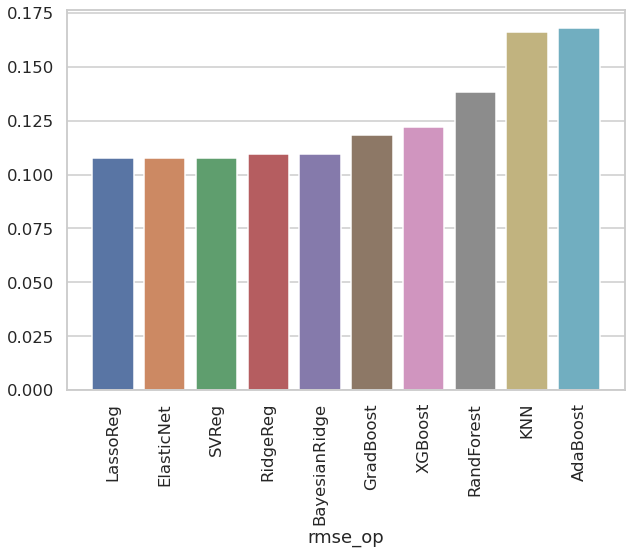

In [318]:
best_scores = [randon_forest_best_score, adaboost_best_score, gradient_boost_best_score, extreme_gradient_boost_best_score, 
               ridge_best_score, lasso_best_score, elastic_net_best_score, bayesian_ridge_best_score,
               sv_regression_best_score, knn_best_score]

df_best_scores = pd.DataFrame()
df_best_scores["rmse_op"] = best_scores
df_best_scores.index = all_models_names
df_best_scores
# all_models_names
plot_serie(df_best_scores["rmse_op"].sort_values(), "rmse_op")

In [261]:
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax


# skewed_columns = list(skewness[(skewness.values > 0.5)].index) + list(skewness[(skewness.values < -0.5)].index)

# boxcox_columns = []
# for i in skewed_columns:
#     boxcox_columns.append(i + "_boxcox")
#     data[i + "_boxcox"] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))
# # 

# skewness = data[boxcox_columns].skew()
# skewness.sort_values(inplace=True, ascending=False)
# plot_dist(skewness)

# # skewness = data[boxcox_columns].skew()
# plot_dist(skewness_scaled)
# skewness_scaled.sort_values()

# for column in boxcox_columns:
#     plot_dist(data[column])
    
# plot_dist(data["SalePrice" + "_log"])
# # data["LotArea_Log"] = np.log1p(data["LotArea"])
# # plot_dist(data["LotArea_Log"])
# # data["LotArea_Log"].skew()


# skewed_target = list(boxcox_columns) 
# skewed_target.append("SalePrice_log")
# sns.set_theme(style="whitegrid", context="talk")
# triang_corr_plot(data[skewed_target].corr(),  vmax=1, vmin=-1)
# skewed_columns 

# corr_SalePrice = data[boxcox_columns + cat_encoded + ["SalePrice"]].corr()
# triang_corr_plot(corr_SalePrice[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(20), 
#                  vmax=1, vmin=-1, figsize=(4, 12), mask=False, annot=True, annot_kws={"size": 20}, square=False)

# """Selecting the highest correlated atributes on both the categorical and numerical columns"""
# top_6_num = corr_num["SalePrice"].sort_values(ascending=False)[:11]
# top_6_cat = corr_cat["SalePrice"].sort_values(ascending=False)[1:11]
# top = top_6_cat.append(top_6_num).sort_values(ascending=False).index

# """Ploting their correlation"""
# corr_12 = data[top].corr(method="spearman")
# sns.set_theme(style="whitegrid", context="talk")
# triang_corr_plot(corr_12, vmax=1, vmin=-1, figsize=(11, 11))

In [ ]:
# #  I have to group the data by ea
# date_heatmap = data.groupby(["YrSold", "MoSold"]).count()
# date_heatmap = date_heatmap[["SalePrice"]].pivot(index="MoSold", columns="YrSold", values="SalePrice")
#  numerical
# ax = sns.heatmap()

### Ames in February
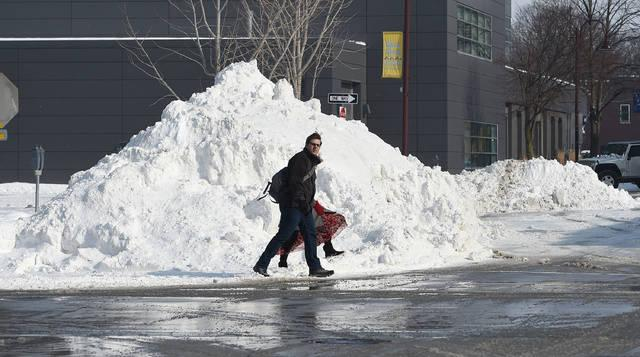

str